# Autoencoder - For Shits n Giggles

I'm going to build a basic Autoencoder just so I have it, going to build it for the MNIST data set

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers, backend, Sequential

import sys
sys.path.insert(1, '../src/')
from data_generator import DataGenerator_array, DataGenerator_file, Plot_Val_Test

# for using GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus=tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

Num GPUs Available:  1


## 1 - Load Data

In [2]:
x_train = np.load('../Data/mnist_fashion/x_train.npy')
x_test = np.load('../Data/mnist_fashion/x_test.npy')
y_train = np.load('../Data/mnist_fashion/y_train.npy')
y_test = np.load('../Data/mnist_fashion/y_test.npy')

In [3]:
DG_train = DataGenerator_array(x_train, 
                               #test_y,
                               batch_size = 1000,
                               to_fit = True,
                               dim = (28,28),
                               shuffle = False,
                               noise = (100, 60)                    
                        )
DG_test = DataGenerator_array(x_test,
                              batch_size = 1000,
                              to_fit = True,
                              dim = (28,28)
                             )

In [6]:
latent_dim = 6

## 2 - build the Encoder
Now, what's pretty cool is the `activity_regularizer` this adds a penality to the loss function at that point.

There exists really three locations for this:  
* at the kernel (kernel_regularizer)
* at the output (activity_regularizer)  
* or at the bias

**Why do we want to use them?** becuase if we don't, then we are, in essence, just training a NN to be like PCA :/

In [7]:
encoder_input = tf.keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=64, 
                  kernel_size=(3,3),
                  #strides=(2, 2), 
                  activation='relu',
                  padding = 'same',
                 kernel_regularizer=tf.keras.regularizers.l1(10e-3))(encoder_input)
x = layers.Flatten()(x)
#x = layers.Dense(20, activation = 'tanh')(x)
x = layers.Dense(latent_dim, 
                 activity_regularizer=tf.keras.regularizers.l1(10e-3),
                activation = 'relu')(x)
Encoder = tf.keras.Model(encoder_input, x)
Encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 301062    
Total params: 301,702
Trainable params: 301,702
Non-trainable params: 0
_________________________________________________________________


## 3 - Build the Decoder

In [14]:
decoder_input = tf.keras.Input(shape = Encoder.layers[-1].output.shape[1:])
x = layers.Dense(latent_dim, 
                 activation = 'relu')(decoder_input)
x = layers.Dense(28*28*64, activation = 'relu')(x)
x = tf.keras.layers.Reshape(target_shape=(28, 28, 64))(x)
x = layers.Conv2DTranspose(
                filters=64, 
                kernel_size=(3,3), 
                #strides=2,
                padding='same',
                activation='relu')(x)
x = layers.Conv2DTranspose(
                filters=1, 
                kernel_size=(3,3), 
                #strides=2,
                padding='same',
                activation='sigmoid')(x)
Decoder = tf.keras.Model(decoder_input, x)
Decoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_7 (Dense)              (None, 50176)             351232    
_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 64)        36928     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 1)         577       
Total params: 388,779
Trainable params: 388,779
Non-trainable params: 0
_____________________________________________________

## 4 - Merging the model together
### *Method 1 - subclassing tf.Model*
The function below mergers the encoder and decord into one model.
the `super(Autoencoder, self)` pulls all the models from the Autoencoder class in tf.Keras.Models, but more importantly **That line HAS TO BE THERE** Don't ask me why, it just does!

*muter muter*  

the `def call` is what tensorflow looks for when it makes a call to this class.  
the `@tf.function` is a tensorflow decorator, for the newest build of TF, you need it, **(maybe, neeed to check on this)** else it will bomb out

In [15]:
class AutoEncoder(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(AutoEncoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
    #@tf.function
   
    def call(self, inputs, training=None, **kwargs):
        x = self.encoder(inputs)
        x = self.decoder(x)
        return x

AE_model = AutoEncoder(Encoder, Decoder)
AE_model.build(input_shape = (None,28,28,1))
AE_model.summary()

Model: "auto_encoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 6)                 301702    
_________________________________________________________________
model_5 (Functional)         (None, 28, 28, 1)         388779    
Total params: 690,481
Trainable params: 690,481
Non-trainable params: 0
_________________________________________________________________


### *Method 2 - just merging them*
Another way to merge them, it's a bit....clearer about what's going on as we don't need to create a class for it

In [16]:
aem = tf.keras.Model(encoder_input, Decoder(Encoder(encoder_input)))
aem.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model_1 (Functional)         (None, 6)                 301702    
_________________________________________________________________
model_5 (Functional)         (None, 28, 28, 1)         388779    
Total params: 690,481
Trainable params: 690,481
Non-trainable params: 0
_________________________________________________________________


# 5 - Defining Loss and compiling them

In [17]:
aem.compile(optimizer =  tf.optimizers.Adam(),
              loss = 'binary_crossentropy', #You can also use MSE  or MSA here
              metrics=['mse'])

AE_model.compile(optimizer =  tf.optimizers.Adam(),
                loss = 'MSE',
                metrics = ['mse'])


# 6 - Training

In [18]:
Hist = aem.fit(DG_train, 
                  epochs = 60,
                  validation_data = DG_test)

W1129 20:00:22.675501 140511751972672 ag_logging.py:146] AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x7fcae42dab70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Epoch 1/60
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
60/60 [==============================] - ETA: 0s - loss: 0.6268 - mse: 0.1388

W1129 20:00:27.725061 140511751972672 ag_logging.py:146] AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fcae4437c80> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
60/60 [==============================] - 5s 76ms/step - loss: 0.6258 - mse: 0.1383 - val_loss: 0.5008 - val_mse: 0.0883
Epoch 2/60
60/60 [==============================] - 4s 73ms/step - loss: 0.4964 - mse: 0.0881 - val_loss: 0.4925 - val_mse: 0.0867
Epoch 3/60
60/60 [==============================] - 4s 73ms/step - loss: 0.4914 - mse: 0.0869 - val_loss: 0.4920 - val_mse: 0.0867
Epoch 4/60
60/60 [==============================] - 4s 73ms/step - loss: 0.4908 - mse: 0.0871 - val_loss: 0.4919 - val_mse: 0.0867
Epoch 5/60
60/60 [==============================] - 4s 73ms/step - loss: 0.4908 - mse: 0.0869 - val_loss: 0.4918 - val_mse: 0.0867
Epoch 6/60
60/60 [===========================

# 7 - Looking at how well it did

W1129 20:04:52.850067 140511751972672 ag_logging.py:146] AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x7fcae4287840> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


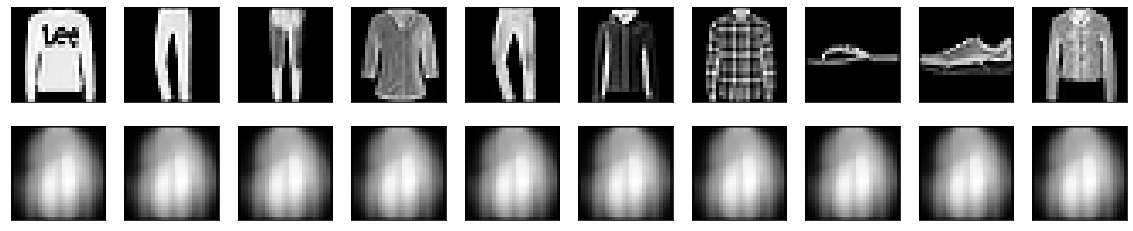

In [19]:
decoded_imgs = aem.predict(x_test/255.0)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


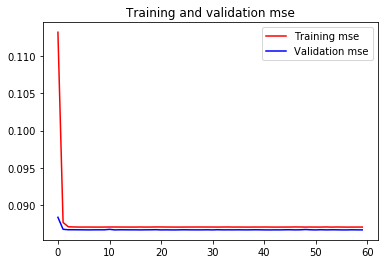

<Figure size 432x288 with 0 Axes>

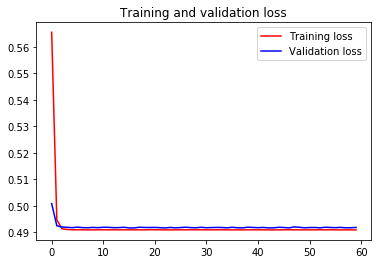

<Figure size 432x288 with 0 Axes>

In [20]:
Plot_Val_Test(Hist, 'mse')

Plot_Val_Test(Hist,'loss')